# Tutorial on using the greedy fit in pySurrogate.fit

In [1]:
import sys, os
sys.path.insert(0, os.path.realpath('..'))

In [2]:
import numpy as np
import pySurrogate as pySur
fit = pySur.fit
fit_greedy = pySur.fit_greedy
evaluate_fit = pySur.evaluate_fit
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('always')
import random

## Spherical ball test case

**note**: Do not commit this notebook with changes to test values or parameters. It is used as a regression test in test_spherical_ball_fit.

Run this code with 

```python
np.random.seed(0)
random.seed(0)
```

to reproduce the regression test. Note that the random package is used in cross-validation fits as its thread safe

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


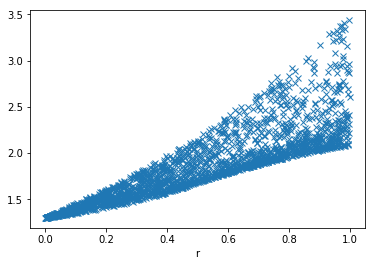

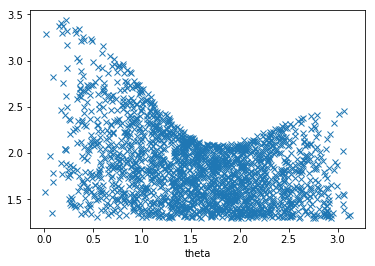

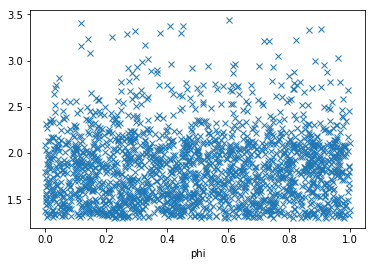

In [3]:
#np.random.seed(0)
#random.seed(0)

# Here is the exact solution (phi-independent)
def f(x, y, z):
    r = np.sqrt(x*x + y*y + z*z)
    return 1.3 + .5*z + np.sin(r)*np.sqrt(1 + 3.*z*z)

# Setup the parameter space
rMax = 1.
def rand_sph_params():
    r = np.random.random()*rMax
    theta = np.arccos(2*np.random.random() - 1.)
    phi = np.random.random()
    return r, theta, phi

def x_y_z(r, theta, phi):
    return r*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

def rand_params():
    r, theta, phi = rand_sph_params()
    return x_y_z(r, theta, phi)                        # So all this does is gets you the x,y,z components corressponding to your r theta phi values

# Sort of plot...
npts = 2000
xVals = np.array([rand_sph_params() for _ in range(npts)])
yVals = np.array([f(*x_y_z(*x)) for x in xVals])
plt.plot(xVals.T[0], yVals, 'x')
plt.xlabel('r')
plt.show()
plt.plot(xVals.T[1], yVals, 'x')
plt.xlabel('theta')
plt.show()
plt.plot(xVals.T[2], yVals, 'x')
plt.xlabel('phi')
plt.show()

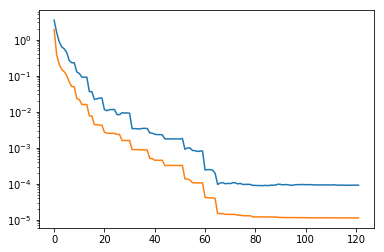

Fit results: 77 coefs, 8.557566088799779e-05 rms max test error, 9.66411629418149e-05 max residual


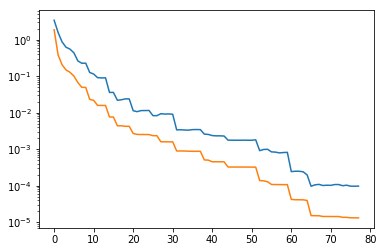

First 10 bfOrders:
[[0 0 0]
 [2 0 0]
 [0 1 0]
 [0 2 0]
 [3 2 0]
 [2 1 0]
 [8 0 0]
 [0 4 0]
 [1 0 0]
 [2 4 0]]


In [4]:
# Let's try fitting to cosines in theta and polynomials in x (What?)
bf_cos = evaluate_fit.BasisFunction('cos', lambda n, x: np.cos(n*x), 0., np.pi)
evaluate_fit.bf_dict['cos'] = bf_cos
bfTypes = ['polynomial', 'cos', 'polynomial']

minVals = np.array([-rMax, 0., 0.])
maxVals = np.array([rMax, np.pi, 2.*np.pi])

options = {
    'minVals': minVals,
    'maxVals': maxVals,
    'bfMaxOrders': [10, 10, 0],
    'absTol': 1.e-8,
    'bfTypes': bfTypes,
}

result = fit.fitWrapper(xVals, yVals, **options)
plt.semilogy(result['maxResids'])
plt.semilogy(result['rmsResids'])
plt.show()

# Do cross validation to make sure this is actually a good fit
options = {
    'minVals': minVals,
    'maxVals': maxVals,
    'bfTypes': bfTypes,
    'bfMaxOrders': [10, 10, 0],
    'rmsCutoff': 'crossValidation',
    'cv_N': 100,
    'cv_nTrials': 10,
}
result_CV = fit.fitWrapper(xVals, yVals, **options)
plt.semilogy(result_CV['maxResids'])
plt.semilogy(result_CV['rmsResids'])
plt.show()

print( "First 10 bfOrders:" )
print( result_CV['bfOrders'][:10] )

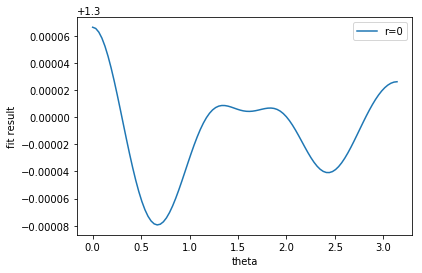

In [6]:
# Some basis function combinations vary in theta but not in r (the 3rd one is just cos(theta), independent of r)
# At r=0 this is a problem! The value of theta should not affect the fit evaluation.

ffunc = evaluate_fit.getFitEvaluator(result_CV)
thetaVals = np.linspace(0., np.pi, 100)
plt.plot(thetaVals, np.array([ffunc([0., theta, 0.]) for theta in thetaVals]), label='r=0')
plt.xlabel('theta')
plt.ylabel('fit result')
plt.legend()
plt.show()

Using test bfMaxOrders


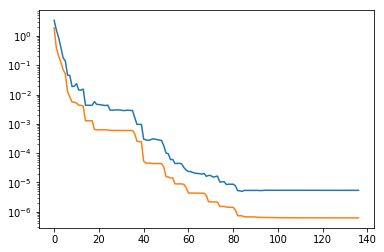

In [7]:
# We should only allow n_theta >= n_r. This ensures (I think...) c^\infty at the origin.

options = {
    'minVals': minVals,
    'maxVals': maxVals,
    'bfMaxOrders': 'test 15 15 0',
    'absTol': 1.e-8,
    'bfTypes': bfTypes,
}

result = fit.fitWrapper(xVals, yVals, **options)
plt.semilogy(result['maxResids'])
plt.semilogy(result['rmsResids'])
plt.show()

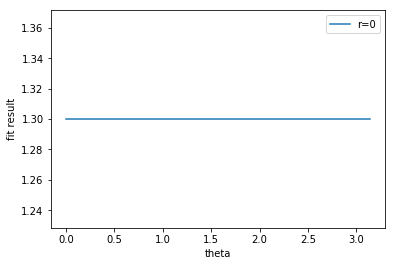

In [8]:
ffunc = evaluate_fit.getFitEvaluator(result)
thetaVals = np.linspace(0., np.pi, 100)
plt.plot(thetaVals, np.array([ffunc([0., theta, 0.]) for theta in thetaVals]), label='r=0')
plt.xlabel('theta')
plt.ylabel('fit result')
plt.legend()
plt.show()

Much better!

In [9]:
result_CV["coefs"][-1]

-0.0059750702643164375

In [10]:
result_CV["maxResids"][-1]

9.66411629418149e-05